In [2]:
import cv2
import commonfunctions as cf
import numpy as np
import matplotlib.pyplot as plt
from numba import njit,prange
# import nbimporter
# from count_rows import count_rows

img shape: (464, 1557), max=255, min=0,median=255.0 and type uint8


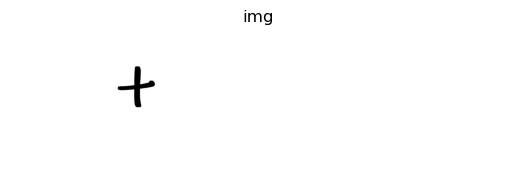

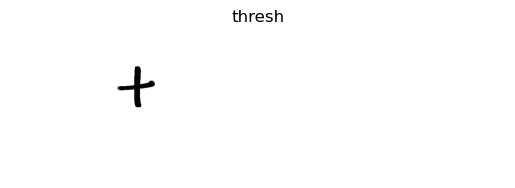

contours before area filtering
3973.5, -720428.0, 
contours after area filtering
3973.5, 
masks


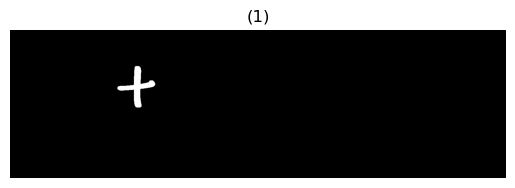

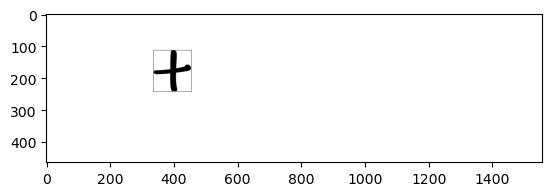

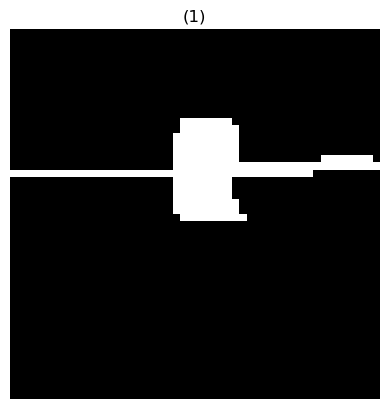

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
# Load the image
def get_letters(img, show_trace = False, single_letter = False):
    # convert to grayscale
    # img = cv2.resize(img, (0,0),fx=0.5, fy=0.5)
    if(show_trace):
        print(f'img shape: {img.shape}, max={img.max()}, min={img.min()},median={np.median(img)} and type {img.dtype}')
        cf.show_images([img],['img'])
    
    h,w = img.shape
    retSize = (50,50)
    
    tolerance = 0.07 * w 
    ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    
    if(single_letter):
        return [cv2.resize(img.max() - img , retSize)] 
    
    if(show_trace):
        cf.show_images([thresh],['thresh'])
    # Find the contours
    contours,_ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    if(show_trace):
        print('contours before area filtering')
        for cnt in contours:
            print(cv2.contourArea(cnt,True),end=', ')
        print()
    # only keep the contours that are black  and i needed to discard the small parts
    contours = list(filter(lambda cnt: cv2.contourArea(cnt,True) >  (0  if(single_letter) else 10), contours))
    if(show_trace):
        print('contours after area filtering')
        for cnt in contours:
            print(cv2.contourArea(cnt,True),end=', ')
        print()
    # sort contours from left to right
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
    contours_list = [(x,y,w,h) for x,y,w,h in [cv2.boundingRect(c) for c in contours]]

    # put masks on the image to get the each letter individually
    masks = []
    for cont in contours:
        mask = np.zeros(img.shape, np.float32)
        cv2.drawContours(mask, [cont], 0, (1,1,1),-1)
        masks.append(mask)
        
    #sort contours from left to right
    # contours_list = sorted(contours_list, key=lambda ctr: ctr[0])3


    # merge list that are too close in x axis
    
    def union(a,b):
        '''
        union of two BoxRectangles 
        '''
        x = min(a[0], b[0])
        y = min(a[1], b[1])
        w = max(a[0]+a[2], b[0]+b[2]) - x
        h = max(a[1]+a[3], b[1]+b[3]) - y
        return (x, y, w, h)

    for ind,(x,y,w,h) in enumerate(contours_list):
        prev_x = float('-inf') if ind == 0 else contours_list[ind-1][0]   
        prev_h = float('-inf') if ind == 0 else contours_list[ind-1][3]   
        if (x - prev_x < tolerance and abs(h - prev_h) < tolerance/2)  or (single_letter and ind != 0):
            # merge contours 
            contours_list[ind] = union(contours_list[ind],contours_list[ind-1])
            contours_list.pop(ind-1)
            # merge masks of the letters
            masks[ind] = masks[ind] + masks[ind-1]
            masks.pop(ind-1)
            ind -=1
            
    if(show_trace):
        print('masks')
        cf.show_images(masks)
    # For each contour, find the bounding rectangle and draw it
    ret_images = []
    for ind,(x,y,w,h) in enumerate(contours_list):
        new_img  = np.logical_and( ~img, masks[ind])[ 0 :  img.shape[0] ,x:x+w].astype(np.uint8)
        ret_images.append(new_img)
        if(show_trace):
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1) #crop 
            # cv2.putText(img, str(ind), (x,y), cv2.FONT_ITALIC, 1, (0,0,255), 2, cv2.LINE_AA)
    
    
    if(show_trace):
        plt.imshow(img)
        plt.show()
        
 
    for i in range(len(ret_images)):
        if(ret_images[i].shape != (0,0)):
            ret_images[i] = cv2.resize(ret_images[i], retSize)
        
    if(show_trace):
        cf.show_images(ret_images)
        
    if(len(ret_images) == 0):
        return [cv2.resize(img.max()-img, retSize)]
    
    return ret_images
    

# from skimage.morphology import skeletonize
# img =  cv2.cvtColor(cv2.imread("test_images/5.png"), cv2.COLOR_BGR2GRAY)

# # apply skeletonization 
# # perform skeletonization
# letters = get_letters(img,show_trace=True);
# skeleton = skeletonize(letters[0])
# cf.show_images([skeleton],['skeleton'])

# letter = cv2.cvtColor(cv2.imread('./datasets/Img/img005-047.png'), cv2.COLOR_BGR2GRAY)
# # draw histogram 


# cf.show_images(get_letters(letter,show_trace=True))

img =  cv2.cvtColor(cv2.imread('./test_images/classification/+1.png'), cv2.COLOR_BGR2GRAY)
letters = get_letters(img,show_trace=True);
# skeleton = skeletonize(letters[0])
# cf.show_images([skeleton],['skeleton'])

In [4]:
# import os
# from os import listdir

# dataset = []
# #load dataset
# folder_dir = r"./datasets/symbols/eval/plus val/"
# for image in os.listdir(folder_dir):
#     dataset.append(cv2.cvtColor(cv2.imread(folder_dir+'/'+image), cv2.COLOR_BGR2GRAY))
    
    
# # get the letters from the dataset
# letters = []
# for img in dataset:
#     letters.append(get_letters(img,single_letter=True))

# count = 0
# # write the letters to the disk
# for i in range(len(letters)):
#     if(len(letters[i]) >1):
#         count +=1
#     for j in range(len(letters[i])):
#         cv2.imwrite('./datasets/letters/'+str(i)+'-'+str(j)+'.png',(1- letters[i][j])*255)
        

In [5]:


import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import numpy as np
from sklearn import *
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin

from sklearn.metrics import accuracy_score


